In [373]:
import os
import numpy as np
from scipy import (integrate, optimize as op,interpolate as ip)
import scipy
from astropy import units as u
from astropy.table import Table
from glob import glob

import george
from george import kernels

import matplotlib.pyplot as plt

np.random.seed(0)



In [374]:
x = np.loadtxt("x", skiprows=1)
flatx = x.flatten()

In [375]:
flatx

array([0.        , 0.00113988, 0.00149608, ..., 1.00070685, 1.0007097 ,
       1.00071255])

In [376]:
# Load betas.
def construct_beta_matrix(beta_table):
    ls = np.unique(beta_table["l"]).size
    ns = np.unique(beta_table["n"]).size

    beta = np.nan * np.ones((ls, ns))
    for row in beta_table:
        beta[row["l"] - 1, row["n"] - 1] = row["beta"]
    
    return beta

beta_table = Table.read("beta.dat", format="ascii")
beta = construct_beta_matrix(beta_table)

In [377]:
beta_flat = beta[:,10:27].flatten()

In [378]:
beta_flat.shape

(51,)

In [379]:
freq_table = Table.read("freq.dat", format="ascii")

omega_sampling = 100
l_degrees = (1, 2, 3) # TODO, this is hard coded elsewhere too

# TODO: why we do this?
n_lower, n_upper = (9, 27)
freq_nl = freq_table[(n_upper > freq_table["n"]) * (freq_table["n"] > n_lower)]

flat_frequencies = np.hstack(
    [freq_nl["Freqs"][freq_nl["l"] == l] for l in l_degrees]
)


flat_splitting = np.hstack(
    [freq_nl["delta"][freq_nl["l"] == l] for l in l_degrees]
)

flat_err = np.hstack(
    [freq_nl["e_delta"][freq_nl["l"] == l] for l in l_degrees]
)

In [380]:
flat_err = flat_err/1e9

In [381]:
datas = flat_splitting/beta_flat

In [382]:
def load_kernels(dirname="kerns/", size=4800):
    paths = glob(dirname + "/l.*_n.*")
    max_l = 1 + max([int(path.split(".")[1].split("_")[0]) for path in paths])
    max_n = 1 + max([int(path.split(".")[-1]) for path in paths])

    kerns = np.nan * np.ones((max_l, max_n, size))

    for l in range(1 + max_l):
        for n in range(1 + max_n):
            path = os.path.join(dirname, "l.{l:.0f}_n.{n:.0f}".format(l=l, n=n))
            if not os.path.exists(path):
                # TODO: some warning?
                continue
            
            kerns[l, n, :] = np.loadtxt(path, skiprows=1)

    return kerns

kern = load_kernels()

In [383]:
kern_restricted = kern[1:34,10:27,:].flatten()

In [384]:
flat_kerns = kern[1:4,10:27,:].reshape(51,4800)

In [385]:
modelS = Table.read('modelS.dat', format="ascii")

# acoustic depth: tau(r) = int_r^R 1/c(x) dx (Aerts et al. eqn. 3.228)
cs = np.sqrt(modelS['c2'])
r  = modelS['r']
tau = np.hstack([0, -integrate.cumtrapz(1/cs, r)])

avg_c_inv = trapz(-1./cs,r)/np.max(r)
w = 1/(np.flip(cs)*avg_c_inv)

x[0] = modelS['x'][-1]
newtau =  ip.interp1d(modelS['x'], tau)(x)

neww = ip.interp1d(modelS['x'], w)(x)

# x_diffs = np.zeros_like(newtau)
# for j in range(1,len(newtau)):
#     x_diffs[j] = np.abs(newtau[j] - newtau[j-1])
    

x_diffs = np.zeros_like(flatx)
for j in range(1,len(flatx)):
    x_diffs[j] = np.abs(flatx[j] - flatx[j-1])

/Users/tawil10/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: scipy.trapz is deprecated and will be removed in SciPy 2.0.0, use numpy.trapz instead
  


In [386]:
R = modelS['r'][0]
r = R * x

In [387]:
eij = np.zeros((51,51))

np.fill_diagonal(eij,flat_err)

[[ 1.          0.          0.         ...  0.          0.
   0.        ]
 [ 1.00000107 -0.00596556  0.4962491  ...  0.53404716  1.
   0.        ]
 [ 0.9999988  -0.01068097  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.99999364 -0.02018975  0.51517819 ...  0.          0.
   0.        ]
 [ 0.99999044 -0.02023182  0.51169503 ...  0.          0.
   0.        ]
 [ 0.          1.          0.         ...  0.          0.
   0.        ]] [[5.14302413e-02 1.00056571e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.00056571e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 3.02741575e-02 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.40567372e-10
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  8.19369569e-09 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.000

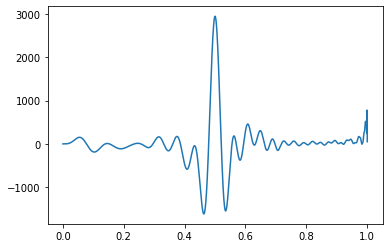

In [441]:
ro = 0.5




#optimize alpha from a single point then use this relation for the rest of the stat
#scaling_delta = alpha/8 * cs/(R*vmax)
scaling_delta = 1e-3

tau = 1/(scaling_delta*np.sqrt(2*np.pi)) * np.exp(-0.5*((flatx-ro)/scaling_delta)**2)

#Ti = trapz[tau*flatkerns,newtau]

Ti = np.ones(52)

for i in range(51):
    Ti[i] = np.trapz((tau*flat_kerns[i]),flatx)


beta= 0.01

Kij = np.zeros((52,52))
for i in range(51):
    for j in range(51):
        Kij[i,j] = beta * np.trapz(flat_kerns[i]*flat_kerns[j],flatx)

vals = np.dot(x_diffs,flat_kerns.T)
Kij[:-1,51] = vals
Kij[51,:-1] = vals

Kij[51,51] = 0
        
def aij_matrix(mu):
    Aij = Kij.copy()
    Aij[0:51,0:51] = Aij[0:51,0:51] + mu*eij
    return Aij






aij = aij_matrix(1e-3)

#print(aij)


#ldl decomp try.
L_mat,d_mat,lt_mat = scipy.linalg.ldl(aij)
print(L_mat,d_mat,lt_mat)

c = np.linalg.solve(aij,Ti)





#minimize Aij for mu and scaling_delta


#invert Aij
special_k = np.zeros(4800)
rot = 0
for i in range(51):
    special_k = special_k + c[i]*flat_kerns[i]
    rot = rot + c[i] * datas[i]

    
val = np.trapz(special_k,flatx)

plt.plot(flatx,special_k)
print(r_0.shape)
#plt.plot(flatx,r_0)


#print(rot,val)

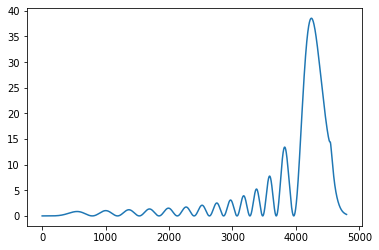

In [428]:
plt.plot(flat_kerns[4])
#plt.ylim(0,10)

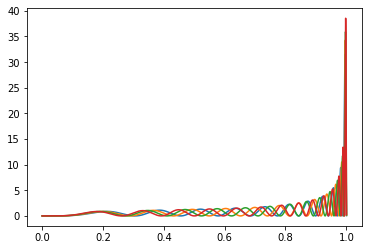

In [327]:
plt.plot(flatx,flat_kerns[1:5].T)

/Users/tawil10/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: scipy.trapz is deprecated and will be removed in SciPy 2.0.0, use numpy.trapz instead
  


0.9999999957013277

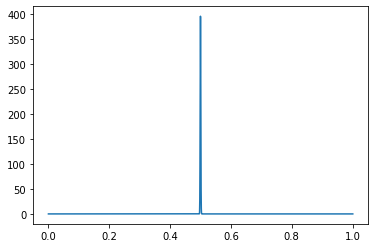

In [435]:
plt.plot(flatx,tau)
scipy.trapz(tau,flatx)

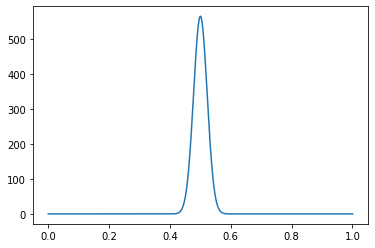

In [309]:
plt.plot(flatx,tau)

In [411]:
c

array([-8.67573693e+00,  3.83626106e+03, -1.39390276e+04,  1.58975859e+04,
       -1.27882469e+04, -7.67278723e+03, -9.55036724e+04,  2.59932241e+05,
       -1.58439699e+05,  1.85156250e+04, -3.65142810e+04,  2.28124698e+04,
       -1.94556411e+04,  2.66912813e+04,  1.20577560e+04, -2.07487170e+04,
        4.25265950e+03,  1.80432207e+02, -3.92808673e+03,  8.54446945e+03,
       -6.72730133e+03,  3.24099729e+03,  1.12135548e+03,  8.45352427e+04,
       -1.14181087e+05,  2.25079233e+04, -7.83072665e+03,  1.65327841e+04,
       -2.82089457e+03,  1.24557582e+04, -3.75072213e+03, -8.91950049e+03,
        3.89761483e+03, -1.90457578e+02, -2.52164267e+03,  1.25099993e+04,
       -1.74296988e+04,  1.41180261e+04,  3.82016677e+03,  6.29243315e+04,
       -2.53557113e+05,  2.00667363e+05, -2.27111093e+04,  3.31179201e+04,
       -2.94514632e+04,  1.50998862e+04, -3.07251025e+04, -7.12829591e+03,
        2.33172699e+04, -5.65690898e+03,  1.44383797e+01, -3.42295915e-01])

In [412]:
Ti = np.dot(x_diffs,(tau*flat_kerns).T)

In [413]:
tau.shape

(4800,)

In [414]:
flat_kerns.shape

(51, 4800)

In [415]:
(tau*flat_kerns).shape

(51, 4800)

In [416]:
Ti

array([2.16161336e-01, 1.08205472e+00, 1.34159015e+00, 5.81015000e-01,
       2.01656600e-04, 5.41554735e-01, 1.30768763e+00, 1.07366295e+00,
       2.06747177e-01, 1.22063300e-01, 9.85765712e-01, 1.35585668e+00,
       6.01728255e-01, 1.86620291e-04, 5.85156033e-01, 1.36198588e+00,
       9.82938383e-01, 5.23541607e-01, 3.22655715e-02, 5.96189048e-01,
       1.34361424e+00, 1.06277747e+00, 2.07714223e-01, 1.30845811e-01,
       9.46641759e-01, 1.35995670e+00, 6.77738188e-01, 1.81171581e-02,
       4.88125891e-01, 1.30876519e+00, 1.09596383e+00, 2.00564840e-01,
       1.55813836e-01, 1.05355581e+00, 1.35993355e+00, 8.42200937e-01,
       1.25155705e-01, 3.10298219e-01, 1.12374869e+00, 1.28239914e+00,
       5.43943283e-01, 3.60277444e-02, 5.81137794e-01, 1.32902785e+00,
       1.05493897e+00, 1.96962471e-01, 1.69833158e-01, 1.03299326e+00,
       1.34533682e+00, 5.66924882e-01, 1.83278863e-02])

In [417]:
np.dot(c[:-1],datas)

-726502.8107830435

In [340]:
datas.shape

(51,)

In [353]:
datas

array([448.32621319, 435.79278777, 445.5330832 , 456.26346453,
       433.83121053, 449.67665814, 408.23499764, 451.30194193,
       452.13325291, 469.05806692, 456.86977878, 450.71843412,
       458.64438377, 461.55233217, 418.32225374, 465.38836567,
       457.28380446, 395.74635649, 403.2917601 , 393.78450788,
       400.44987819, 397.06736702, 405.86350934, 397.56236856,
       409.42938043, 392.14671219, 396.99530591, 398.85879147,
       405.75372617, 400.60922335, 400.50422928, 425.48909074,
       402.31953106, 424.30602917, 434.00345257, 434.50836732,
       432.02678608, 441.73558328, 439.35589443, 440.08095132,
       450.92214997, 439.62018409, 444.45374705, 460.35176713,
       442.09239513, 445.97248917, 457.88534893, 466.79651731,
       441.59203924, 409.38002811, 398.26266702])